In [1]:
import pickle

import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from matplotlib.pyplot import cm
from nilearn import datasets, plotting
from nilearn.maskers import NiftiMapsMasker
from tqdm import tqdm 

from fsdiffnet.utils import keep_largest_k
from fsdiffnet.infer import infer_differential_graph

/data1/jcleng/software/anaconda3/envs/py310/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
atlas = datasets.fetch_atlas_msdl(
    './data/ABIDE_data')
# Loading atlas image stored in 'maps'
atlas_filename = atlas['maps']
# Loading atlas data stored in 'labels'
labels = atlas['labels']

coords = atlas.region_coords

masker = NiftiMapsMasker(maps_img=atlas_filename, standardize=True,
                         memory='nilearn_cache', verbose=5)

TIME_SERIES = pickle.load(open('./data/ABIDE_data/TIME_SERIES_YALE', 'rb'))
TIME_SERIES1 = TIME_SERIES[0]
TIME_SERIES2 = TIME_SERIES[1]

In [3]:

PRED_MAT = np.zeros((39, 39))
input_matrix = torch.zeros(len(TIME_SERIES1)*len(TIME_SERIES2),2,39,39)
for i in tqdm(range(len(TIME_SERIES1))):
    for j in tqdm(range(len(TIME_SERIES2)), leave=False):
        # print(f"i:{i},j:{j}")
        time_series1 = TIME_SERIES1[i]
        time_series2 = TIME_SERIES2[j]

        cov1 = np.corrcoef(time_series1.T)
        cov2 = np.corrcoef(time_series2.T)
        input_matrix[i*len(TIME_SERIES2) + j]
        input_ = torch.stack((torch.as_tensor(cov1), torch.as_tensor(cov2))).cuda()
        input_ = input_.unsqueeze(0).float()
        pred_mat = infer_differential_graph(input_, scale='normal',para_file='ABIDE')
        PRED_MAT += pred_mat


PRED_MAT /= len(TIME_SERIES1)*len(TIME_SERIES2)
# ASD - NORMAL
PRED_MAT = -PRED_MAT

  0%|          | 0/22 [00:00<?, ?it/s]

100%|██████████| 22/22 [00:20<00:00,  1.07it/s]


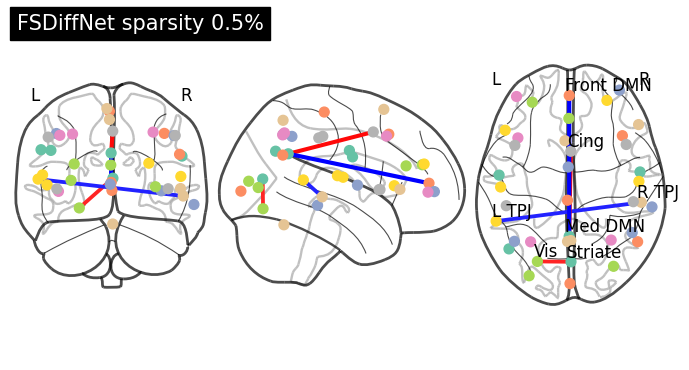

In [4]:

#----------------- sparsity 0.005 ----------------------
sparsity = 0.005

PRED_MAT05 = keep_largest_k(PRED_MAT, int(np.ceil((39**2-39)/2*sparsity)*2))

# connectome visualization
plotting.plot_connectome(
    PRED_MAT05, coords, edge_threshold="0%", title='FSDiffNet sparsity 0.5%')
for i in range(len(PRED_MAT05[0])):
    if np.sum(abs(PRED_MAT05), 0)[i] > 0:
        plt.annotate(labels[i], xy=(coords[i][0], coords[i][1]), xytext=(
            coords[i][0]-3.0, coords[i][1]+3.1), zorder=2000, fontsize=12)  # 这里xy是需要标记的坐标，xytext是对应的标签坐标
# plt.savefig('./results/nilearn/YALE/DDN_sparse05_net.pdf', format='pdf', dpi=300)


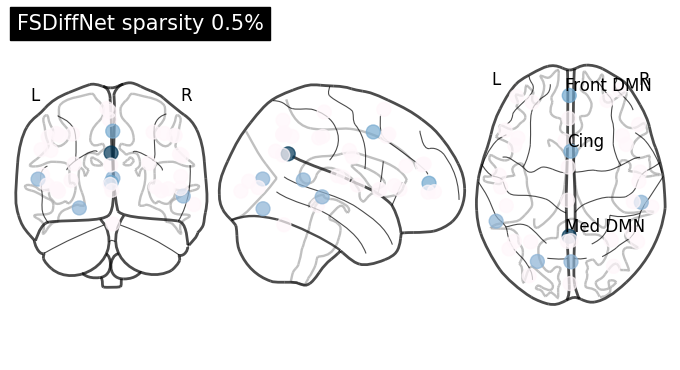

In [5]:

# strength visualization
strength_ = np.sum(abs(PRED_MAT05), 0)
plotting.plot_markers(strength_, coords,title='FSDiffNet sparsity 0.5%' ,node_cmap=cm.PuBu, colorbar=False)
for i in range(len(strength_)):
    if strength_[i] > np.percentile(strength_, 90):
        plt.annotate(labels[i], xy=(coords[i][0], coords[i][1]), xytext=(
            coords[i][0]-3.0, coords[i][1]+3.1), zorder=2000, fontsize=12)



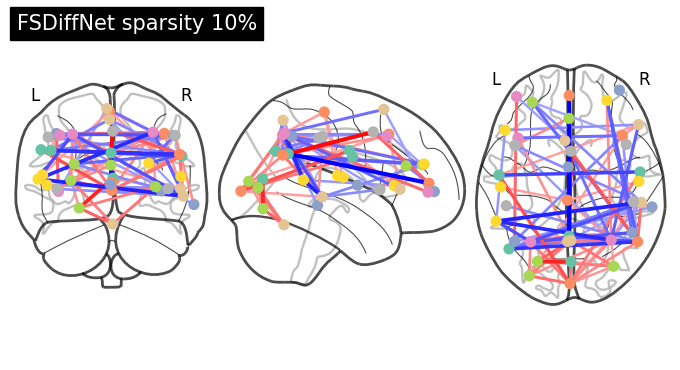

In [6]:


#----------------- sparsity 0.1 ----------------------
sparsity = 0.1

PRED_MAT10 = keep_largest_k(PRED_MAT, int(np.ceil((39**2-39)/2*sparsity)*2))

# connectome visualization
plotting.plot_connectome(
    PRED_MAT10, coords, edge_threshold="0%", title='FSDiffNet sparsity 10%')



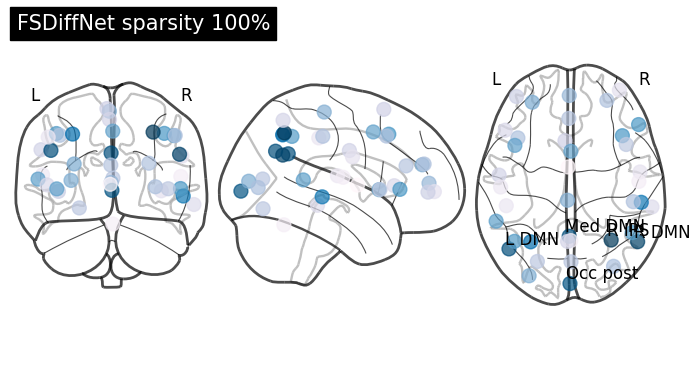

In [7]:

#----------------- sparsity 100 region strength plot ----------------------

# strength visualization
strength_ = np.sum(abs(PRED_MAT), 0)
plotting.plot_markers(strength_, coords,title='FSDiffNet sparsity 100%' ,node_cmap=cm.PuBu, colorbar=False)
for i in range(len(strength_)):
    if strength_[i] > np.percentile(strength_, 88):
        plt.annotate(labels[i], xy=(coords[i][0], coords[i][1]), xytext=(
            coords[i][0]-3.0, coords[i][1]+3.1), zorder=2000, fontsize=12)  # 这里xy是需要标记的坐标，xytext是对应的标签坐标


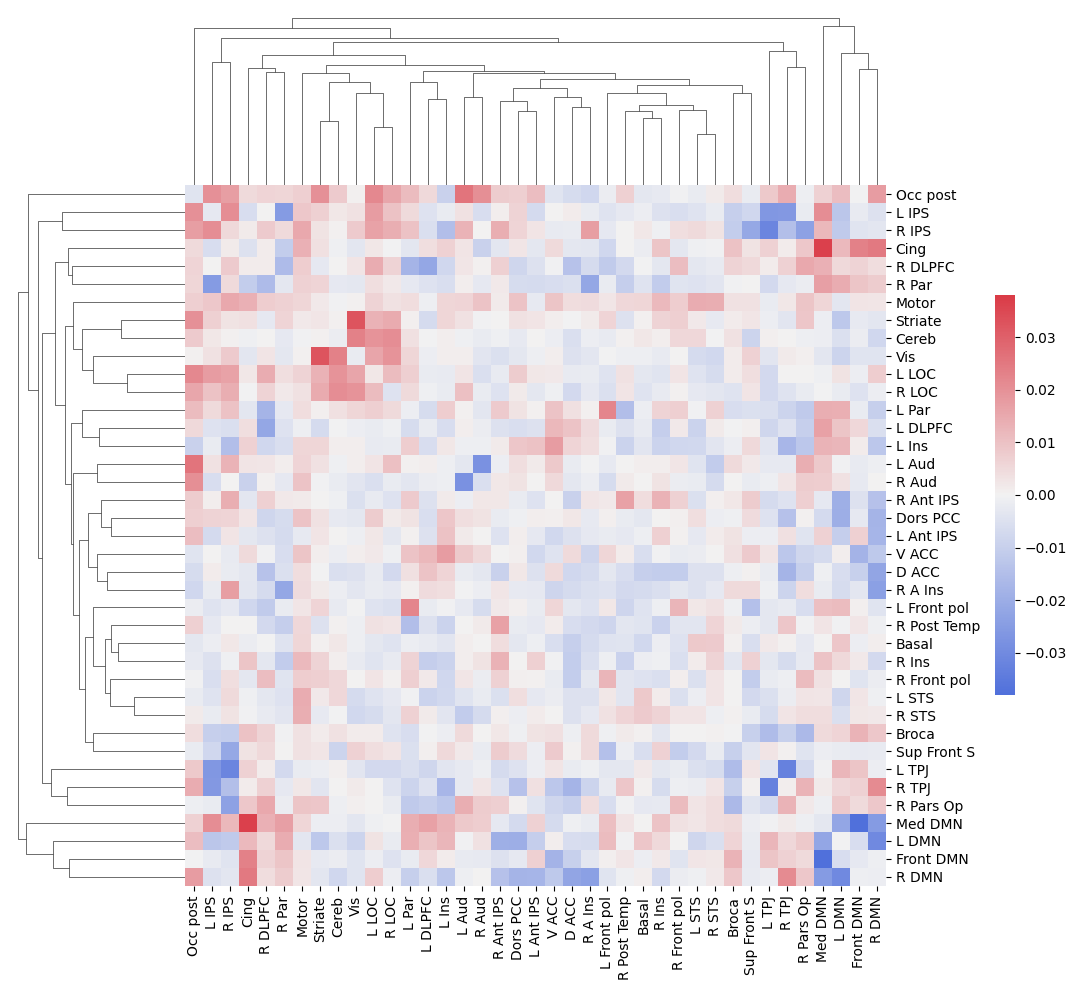

In [8]:

# cluserting adjacency matrix
cmap = sns.diverging_palette(260, 10, as_cmap=True)
vmax = np.max(np.abs(PRED_MAT))
sns.clustermap(PRED_MAT,xticklabels=labels,yticklabels=labels,vmax=vmax,vmin=-vmax,cmap=cmap, metric='euclidean')
plt.gcf().axes[-1].set_position([1, 0.3, 0.02, 0.4])
plt.show()


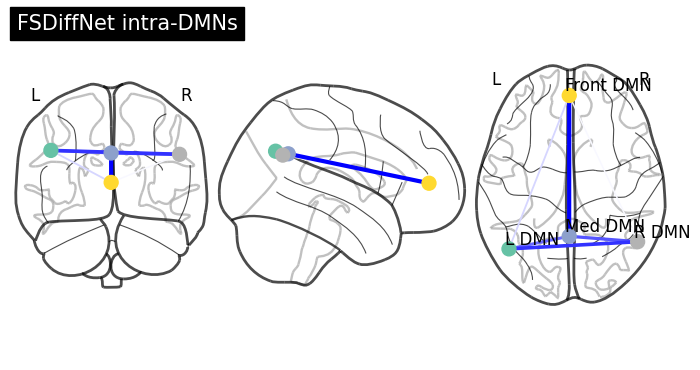

In [9]:
    
#----------------- DMN plot ----------------------
DMNindex = ['DMN' in i for i in labels]
DMNindex = np.array(DMNindex)
PRED_MAT_DMN = PRED_MAT.copy()
PRED_MAT_DMN[~DMNindex,:]=0
PRED_MAT_DMN[:,~DMNindex]=0
PRED_MAT_DMN = PRED_MAT[DMNindex][:,DMNindex]
coords_DMN = [coords[i]  for i in range(len(coords)) if DMNindex[i] ]
DMN_labels = [labels[i]  for i in range(len(coords)) if DMNindex[i] ]

# connectome visualization
plotting.plot_connectome(
    PRED_MAT_DMN, coords_DMN, edge_threshold="0%", title='FSDiffNet intra-DMNs', node_size=100,)
for i in range(len(PRED_MAT_DMN[0])):
    if np.sum(abs(PRED_MAT_DMN), 0)[i] > 0:
        plt.annotate(DMN_labels[i], xy=(coords_DMN[i][0], coords_DMN[i][1]), xytext=(
            coords_DMN[i][0]-3.0, coords_DMN[i][1]+3.1), zorder=2000, fontsize=12)  # 这里xy是需要标记的坐标，xytext是对应的标签坐标


In [10]:
plotting.view_connectome(PRED_MAT10, coords)